# Toy example to test algorithms for fitting the Potts model with sampling 
The toy example has only 2 nodes (which are connected)
Each node can have four states, node one has $\pi_1=[0.6,0.05,0.01,0.2]$, 
for node 2 the probabilities are flat $\pi_2=0.25$.
Because the 2 nodes are connected with an edge, they will positively correlated when theta_w > 0 and negatively correlated when theta_w < 0
This also means that the marginal probabilities are not equal to the \pi parameters for each node.  

In [40]:
# Preliminaries 
import os
import sys 
sys.path.append(os.path.abspath('..'))
from examples import simulate_potts_gauss_duo, simulate_potts_gauss_duo2, make_duo_model, plot_duo_fit
import matplotlib.pyplot as plt
import copy
import emissions as em
import arrangements as ar
import spatial as sp
from full_model import FullModel
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss

## 1. Fitting of arrangement model (without touching the emission model)
### Example 1.1: independent nodes
In the case that the nodes are independent, the marginals of the true arrangements are the same as $\pi$. 
The model without fitting $\theta_w$ trivially reaches the performance of the independent arrangement models (blue circle)

U2   0.0   1.0   2.0   3.0
U1                        
0.0  8.0  13.0  18.0  18.0
1.0  NaN   1.0   1.0   NaN
2.0  6.0   1.0   3.0   6.0
3.0  4.0   8.0   6.0   7.0
U1
0.0    0.57
1.0    0.02
2.0    0.16
3.0    0.25
dtype: float64
U2
0.0    0.18
1.0    0.23
2.0    0.28
3.0    0.31
dtype: float64


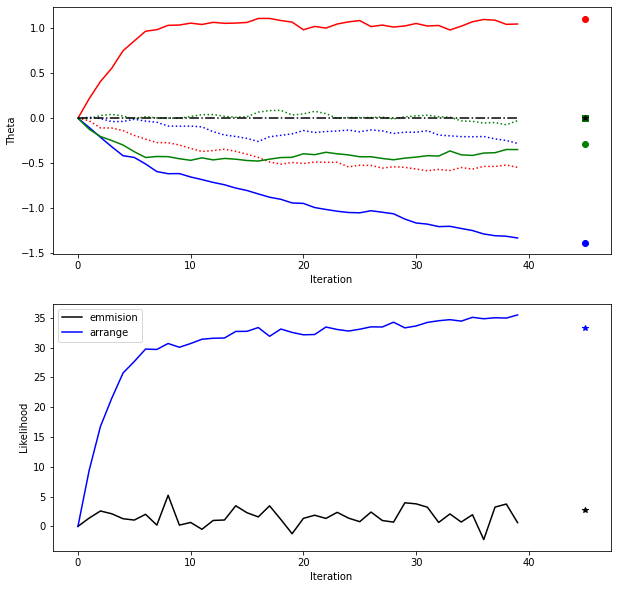

In [3]:

plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=0,sigma2 = 0.1,fit_theta_w=False,numiter=40)

The upper panel showt the parameter estimates (logpi,theta_w) for the 40 interactions. The dots show the true parameter values. The lower panel shows the expected likelihood, split up into emission likelihood and arrangement likelihood. 
The stars show the liklihood of the True model, the circle that of the independent model. 

### Example 1.2: Data is dependent - but fitting model is indepdent
Now we add a coupling term between the two nodes - clearly node 2 starts following the assignment of node 1. 
The model assumes independence of the nodes and therefore thinks that the $\pi_{2,k$ parameters are not equal to 0.25.  

U2    0.0  1.0  2.0   3.0
U1                       
0.0  47.0  2.0  9.0   6.0
1.0   NaN  1.0  NaN   NaN
2.0   1.0  2.0  7.0   1.0
3.0   2.0  NaN  3.0  19.0
U1
0.0    0.64
1.0    0.01
2.0    0.11
3.0    0.24
dtype: float64
U2
0.0    0.50
1.0    0.05
2.0    0.19
3.0    0.26
dtype: float64


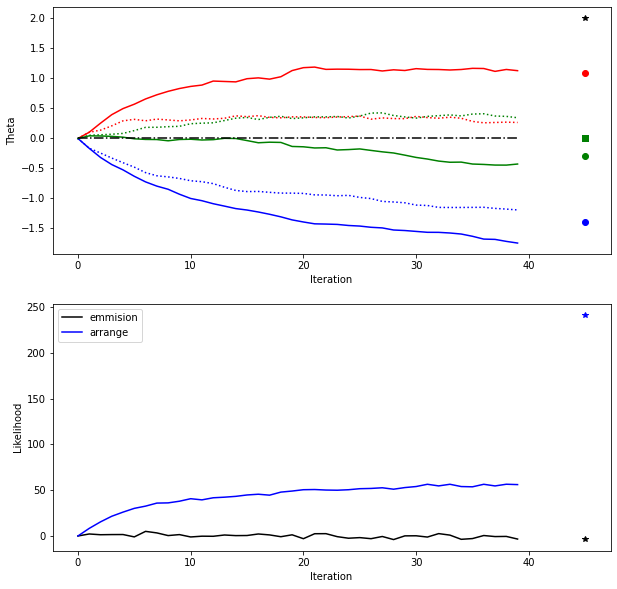

In [4]:
plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=2,sigma2 = 0.1,fit_theta_w=False,numiter=40)

The estimates of $\pi_2$ are biased and the arrangement likelihood is much below the true model. 

### Example 1.3: Dependent data - dependent model
Now we attempt to fit also the coupling term between the two nodes. 

U2    0.0  1.0   2.0   3.0
U1                        
0.0  39.0  5.0   6.0   6.0
1.0   1.0  2.0   NaN   NaN
2.0   1.0  6.0  12.0   NaN
3.0   4.0  1.0   1.0  16.0
U1
0.0    0.56
1.0    0.03
2.0    0.19
3.0    0.22
dtype: float64
U2
0.0    0.45
1.0    0.14
2.0    0.19
3.0    0.22
dtype: float64


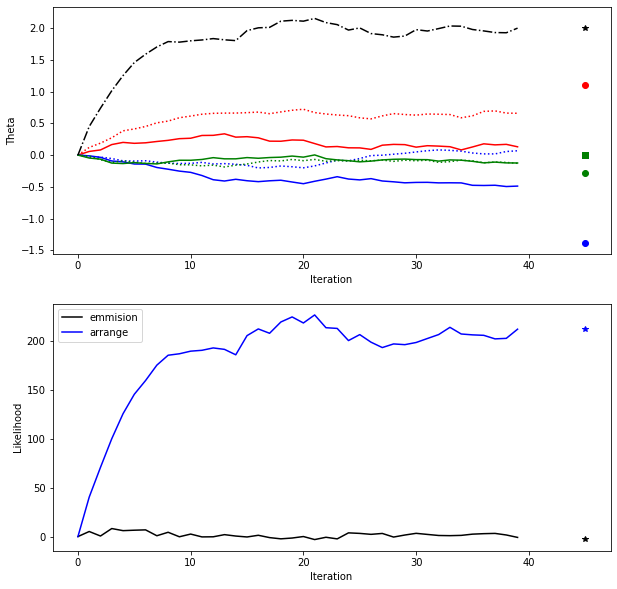

In [5]:
plt.figure(figsize=(10,10))
theta,i,thetaT=simulate_potts_gauss_duo(theta_w=2,sigma2 = 0.1,fit_theta_w=True,numiter=40)

The $\theta_w$ estimates starts increasing, removing the bias on the $pi_2$ parameters and achieving the true arrangement likelihood. 

## 2. Simultaenous fitting of arrangement and emission model
I this example, we are fitting the Arrangement model and the Emission model simulatenously. 
### Example 2.1 Using EM to fit Gaussian Mixture and arrangemenet model

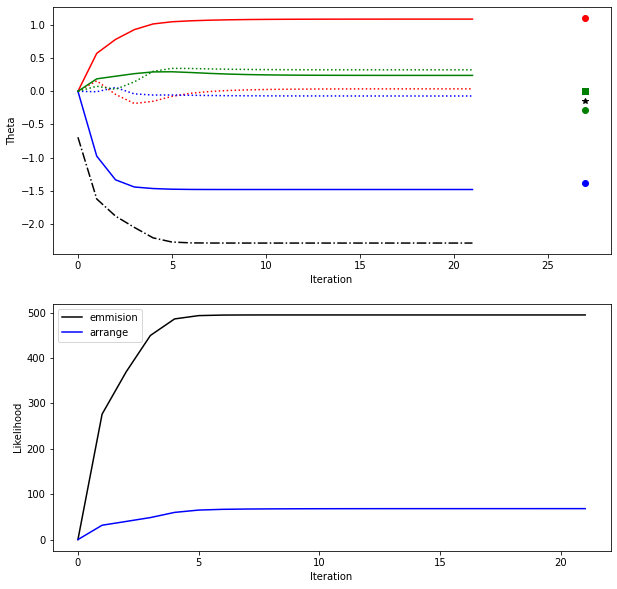

In [111]:
num_subj=100
MT = make_duo_model(K=4,theta_w=0,sigma2=0.1)
theta_true = MT.get_params()

# Generate the data 
U,Y = MT.sample(num_subj=num_subj)

# Step 4: Generate indepedent models for fitting
arrangeI = ar.ArrangeIndependent(K=4, P=2,spatial_specific=True)
emissionI = copy.deepcopy(MT.emission)
emissionI.sigma2=0.5
# Add a small perturbation to paramters 
emissionI.V = emissionI.V + np.random.normal(0,0.1,emissionI.V.shape)
emissionM = copy.deepcopy(emissionI)
MI = FullModel(arrangeI, emissionI)

# Step 5: Fit independent model to the data and plot
pIn = np.concatenate([np.arange(0,6),
            [MI.nparams-1]])
MI,ll,theta = MI.fit_em(Y,iter=30,tol=0.001,seperate_ll=True)
plt.figure(figsize=(10,10))
plot_duo_fit(theta[:,pIn],ll,theta_true = theta_true[pIn])


As can be seen, the emssision model (sigma - dashed-dotted line) fits quite well, but the logpi estimates for node 1 are heavily biased towards zero

### Example 2.2 Fitting Emission and spatial arrangement model 


<Figure size 432x288 with 0 Axes>

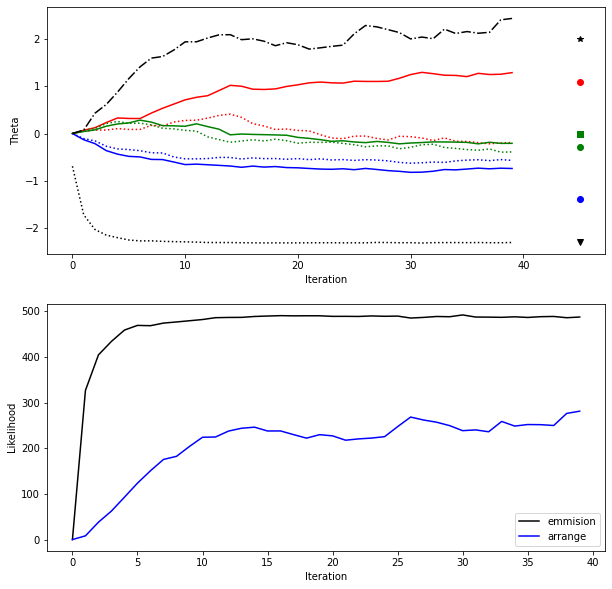

In [15]:
# Step 6: Generate Potts model for fitting
arrangeM = ar.PottsModel(MT.arrange.W, K=4)
arrangeM.theta_w =0
arrangeM.eneg_numchains=100
arrangeM.epos_numchains=20
MP = FullModel(arrangeM, emissionM)

# Step 7: Use stochastic gradient descent to pit the combined model 
plt.figure()
pIn = np.concatenate([np.arange(0,7),
            [MP.nparams-1]])
MP,ll,theta = MP.fit_sml(Y,iter=40,stepsize=0.8,seperate_ll=True)
plt.figure(figsize=(10,10))
plot_duo_fit(theta[:,pIn],ll,theta_true = theta_true[pIn])


## 3. Evaluating models without knowing the partition function
In the above example, we could calculate the expected complete log-liklihood by brute-force calculating the partition function over the P=2 nodes. 
We can therefore compare the two model according to their ELBO as a (lower bound to the marginal likelihood of the model). 
According to this criterion, the Potts model should clearly win over the independent model. 

The problem is that, for the arrangement model, we don't have the partition function in general. So we need to use new set of data to evaluate performance. 
The key question is how we make prediction for this data: 
$\theta_A$: Learned from a set of subjects including or excluding the subject
$\theta_E$ means: Learned from a set of subjects including or excluding the subject 
$\theta_E$ dispersion: Could be optimized / integrated out for each to-be-evluated subject. 
$\langle \mathbf{U} \rangle_q$: 

* Could be unknown (sampling from arrangement negative phase),
* Could be known from independent data or from the test data (expectation)
* Could be complete or partially known (and then inferred for the missing value). 

In this section, we go through a couple of approaches to do this

### 3.1. Baseline: Expected log-liklihood for the subject / data we have

t(100)=-3.336, p=0.0012


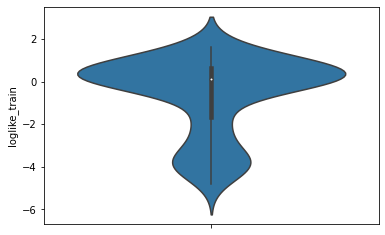

In [96]:
E1={} # Evaluation dictionary 
E2={}
E1['emloglik'] = MI.emission.Estep()
E1['Uhat'],E1['ll_A'] = MI.arrange.Estep(E1['emloglik'])
E1['ll_E'] = np.sum(E1['emloglik'] * E1['Uhat'],axis=(1,2))
E2['emloglik'] = MP.emission.Estep()
E2['Uhat'],E2['ll_A'] = MP.arrange.epos_sample(E2['emloglik'])
E2['ll_E'] = np.sum(E2['emloglik'] * E2['Uhat'],axis=(1,2))
df = pd.DataFrame({'loglike_train':E2['ll_A']+E2['ll_E']-E1['ll_A']-E1['ll_E']})
sns.violinplot(y=df.loglike_train)
t,p=ss.ttest_1samp(df.loglike_train,0)
print(f"t(100)={t:.3f}, p={p:.4f}")

### 3.2. New data from the same subjects - using Uhat from training data 

t(100)=2.162, p=0.0330


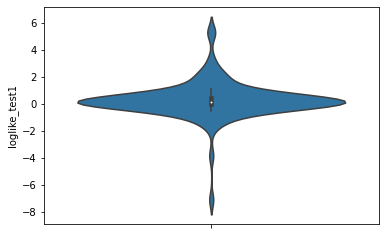

In [93]:
# Get new data from the same subjects
Ytest = MT.emission.sample(U)
MI.emission.initialize(Ytest)
E1['emloglik_test'] = MI.emission.Estep()
E1['ll_E_test'] = np.sum(E1['emloglik_test'] * E1['Uhat'],axis=(1,2))

MP.emission.initialize(Ytest)
E2['emloglik_test'] = MP.emission.Estep()
E2['ll_E_test'] = np.sum(E2['emloglik_test'] * E2['Uhat'],axis=(1,2))
df['loglike_test1']=E2['ll_E_test']-E1['ll_E_test']
sns.violinplot(y=df.loglike_test1)
t,p=ss.ttest_1samp(df.loglike_test1,0)
print(f"t(100)={t:.3f}, p={p:.4f}")

### 3.3. New data from new subjects - using the group atlas


t(100)=8.235, p=0.0000
[[0.60471664 0.45606058]
 [0.06720633 0.0897186 ]
 [0.14337476 0.18865799]
 [0.18470227 0.26556283]]
[[0.67 0.53]
 [0.03 0.03]
 [0.08 0.15]
 [0.22 0.29]]


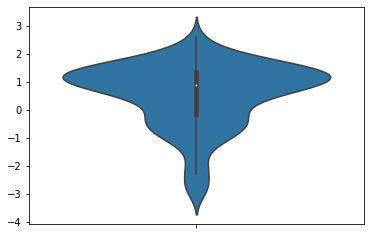

In [108]:
Un,Yn = MT.sample(num_subj=300)
MI.emission.initialize(Yn)
E1['emloglik_ggen'] =  MI.emission.Estep()
E1['U_ggen'] = ar.loglik2prob(MI.arrange.logpi)
E1['ll_E_ggen'] = np.sum(E1['emloglik_ggen']*E1['U_ggen'],axis=(1,2))

MP.emission.initialize(Yn)
E2['emloglik_ggen'] = MP.emission.Estep()
E2['U_ggen'] = MP.arrange.eneg_sample()
E2['ll_E_ggen'] = np.sum(E2['emloglik_ggen'] * E2['U_ggen'],axis=(1,2))

loglike_ggen=E2['ll_E_ggen']-E1['ll_E_ggen']
sns.violinplot(y=loglike_ggen)
t,p=ss.ttest_1samp(loglike_ggen,0)
print(f"t(100)={t:.3f}, p={p:.4f}")
print(E1['U_ggen'])
print(E2['U_ggen'])

# E2['emloglik_ggen'].shape

This behaves very strange in the evaluation - it seems that nearly the subjects are not independent.... 
Sometimes H1 wins, sometimes H0 win, each time highly significant. This shouldn't be the case....